In [44]:
import os
import numpy as np
import torch
from PIL import Image

from torch import nn, optim

import visionutils.transforms as T
from visionutils.engine import train_one_epoch, evaluate
import visionutils.utils

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torchvision.models import resnet18, ResNet18_Weights

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
class ClusterDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "freq_tiles"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "freq_tiles", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        #img = Image.open(img_path).convert("RGB")
        
        with np.load(img_path) as data:
            img = data['arr_0']
        img = np.array(img, dtype='f')

        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        with np.load(mask_path) as data:
            mask = data['arr_0']
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [94]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [95]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [96]:
def get_instance_frcnn_model(num_classes, 
                             backbone_path = "/project/r/rbond/jorlo/ml-clusters/models/torch-act/act-mobilenet.pth"):
    
    backbone_model = torchvision.models.mobilenet_v2()
    backbone_model.fc = nn.Linear(512, 2)

    backbone_model.load_state_dict(torch.load(backbone_path))
    backbone = backbone_model.features
    
    backbone.out_channels = 1280
    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))

    # let's define what are the feature maps that we will
    # use to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.
    # if your backbone returns a Tensor, featmap_names is expected to
    # be [0]. More generally, the backbone should return an
    # OrderedDict[Tensor], and in featmap_names you can choose which
    # feature maps to use.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)
    

    model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
    
    return model

In [97]:
# use our dataset and defined transformations
dataset = ClusterDataset('/project/r/rbond/jorlo/datasets/ACT_tiles/', get_transform(train=True))
dataset_test = ClusterDataset('/project/r/rbond/jorlo/datasets/ACT_tiles/', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=visionutils.utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=visionutils.utils.collate_fn)

In [98]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_frcnn_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [99]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/203]  eta: 1:50:43  lr: 0.000030  loss: 1.8438 (1.8438)  loss_classifier: 0.7085 (0.7085)  loss_box_reg: 0.0019 (0.0019)  loss_objectness: 0.6948 (0.6948)  loss_rpn_box_reg: 0.4386 (0.4386)  time: 32.7290  data: 0.6643  max mem: 5532
Epoch: [0]  [ 10/203]  eta: 0:10:08  lr: 0.000277  loss: 1.8791 (1.9009)  loss_classifier: 0.6986 (0.6944)  loss_box_reg: 0.0012 (0.0012)  loss_objectness: 0.6948 (0.6953)  loss_rpn_box_reg: 0.4804 (0.5099)  time: 3.1526  data: 0.0648  max mem: 6294
Epoch: [0]  [ 20/203]  eta: 0:05:18  lr: 0.000524  loss: 1.8701 (1.8386)  loss_classifier: 0.6436 (0.6355)  loss_box_reg: 0.0012 (0.0012)  loss_objectness: 0.6909 (0.6878)  loss_rpn_box_reg: 0.4804 (0.5141)  time: 0.1910  data: 0.0057  max mem: 6374
Epoch: [0]  [ 30/203]  eta: 0:03:34  lr: 0.000772  loss: 1.5306 (1.6714)  loss_classifier: 0.4461 (0.5429)  loss_box_reg: 0.0013 (0.0014)  loss_objectness: 0.6570 (0.6710)  loss_rpn_box_reg: 0.3959 (0.4560)  time: 0.1843  data: 0.0075  max mem: 6724

Epoch: [1]  [ 50/203]  eta: 0:00:25  lr: 0.005000  loss: 0.4007 (0.4403)  loss_classifier: 0.1301 (0.1488)  loss_box_reg: 0.0004 (0.0013)  loss_objectness: 0.1830 (0.1917)  loss_rpn_box_reg: 0.0861 (0.0984)  time: 0.1463  data: 0.0068  max mem: 7078
Epoch: [1]  [ 60/203]  eta: 0:00:23  lr: 0.005000  loss: 0.3894 (0.4312)  loss_classifier: 0.1298 (0.1463)  loss_box_reg: 0.0005 (0.0012)  loss_objectness: 0.1842 (0.1888)  loss_rpn_box_reg: 0.0769 (0.0949)  time: 0.1484  data: 0.0088  max mem: 7078
Epoch: [1]  [ 70/203]  eta: 0:00:21  lr: 0.005000  loss: 0.3894 (0.4278)  loss_classifier: 0.1298 (0.1457)  loss_box_reg: 0.0005 (0.0013)  loss_objectness: 0.1842 (0.1882)  loss_rpn_box_reg: 0.0733 (0.0926)  time: 0.1492  data: 0.0102  max mem: 7078
Epoch: [1]  [ 80/203]  eta: 0:00:19  lr: 0.005000  loss: 0.3998 (0.4234)  loss_classifier: 0.1333 (0.1444)  loss_box_reg: 0.0006 (0.0015)  loss_objectness: 0.1892 (0.1867)  loss_rpn_box_reg: 0.0733 (0.0909)  time: 0.1466  data: 0.0084  max mem: 7078


KeyboardInterrupt: 

In [16]:
for i, name in enumerate(mask_list):
    print(i, name)

0 1_0_0_mask.npz
1 1_0_10_mask.npz
2 1_0_13_mask.npz
3 1_0_14_mask.npz
4 1_0_15_mask.npz
5 1_0_16_mask.npz
6 1_0_17_mask.npz
7 1_0_18_mask.npz
8 1_0_19_mask.npz
9 1_0_1_mask.npz
10 1_0_2_mask.npz
11 1_0_3_mask.npz
12 1_0_4_mask.npz
13 1_0_5_mask.npz
14 1_0_6_mask.npz
15 1_0_7_mask.npz
16 1_0_8_mask.npz
17 1_0_9_mask.npz
18 1_10_10_mask.npz
19 1_10_11_mask.npz
20 1_10_12_mask.npz
21 1_10_13_mask.npz
22 1_10_14_mask.npz
23 1_10_16_mask.npz
24 1_10_17_mask.npz
25 1_10_18_mask.npz
26 1_10_19_mask.npz
27 1_10_1_mask.npz
28 1_10_20_mask.npz
29 1_10_21_mask.npz
30 1_10_22_mask.npz
31 1_10_23_mask.npz
32 1_10_24_mask.npz
33 1_10_25_mask.npz
34 1_10_2_mask.npz
35 1_10_3_mask.npz
36 1_10_4_mask.npz
37 1_10_5_mask.npz
38 1_10_6_mask.npz
39 1_10_7_mask.npz
40 1_10_8_mask.npz
41 1_10_9_mask.npz
42 1_11_0_mask.npz
43 1_11_10_mask.npz
44 1_11_11_mask.npz
45 1_11_12_mask.npz
46 1_11_13_mask.npz
47 1_11_14_mask.npz
48 1_11_17_mask.npz
49 1_11_18_mask.npz
50 1_11_19_mask.npz
51 1_11_1_mask.npz
52 1_11_2

In [19]:
for j in range(455):
    mask_list = list(sorted(os.listdir(os.path.join('/project/r/rbond/jorlo/datasets/ACT_tiles/', "masks"))))
    mask_path = os.path.join('/project/r/rbond/jorlo/datasets/ACT_tiles/', "masks", mask_list[j])
    with np.load(mask_path) as data:
        mask = data['arr_0']
    # convert the PIL Image into a numpy array
    mask = np.array(mask)
    # instances are encoded as different colors
    obj_ids = np.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]
    # split the color-encoded mask into a set
    # of binary masks
    masks = mask == obj_ids[:, None, None]
    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])
        if xmin==xmax and ymin == ymax:
            print(mask_list[j])
        
        

    # convert everything into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)


37_2_7_mask.npz


In [ ]:
boxes

In [54]:
path = '/project/r/rbond/jorlo/datasets/ACT_tiles/'
tile = '1_0_0'


with np.load(path+'freq_tiles/'+tile+'.npz') as data:
        img = data['arr_0']
with np.load(path+'masks/'+tile+'_mask.npz') as data:
        mask = data['arr_0']
img = np.array(img)
mask = np.array(mask)
# instances are encoded as different colors
obj_ids = np.unique(mask)
# first id is the background, so remove it
obj_ids = obj_ids[1:]
# split the color-encoded mask into a set
# of binary masks
masks = mask == obj_ids[:, None, None]
# get bounding box coordinates for each mask
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])

In [55]:
boxes

[[68, 634, 72, 638],
 [383, 840, 387, 844],
 [466, 137, 470, 141],
 [583, 810, 587, 814],
 [657, 300, 661, 304],
 [818, 387, 822, 391],
 [889, 634, 893, 638],
 [975, 603, 979, 607]]

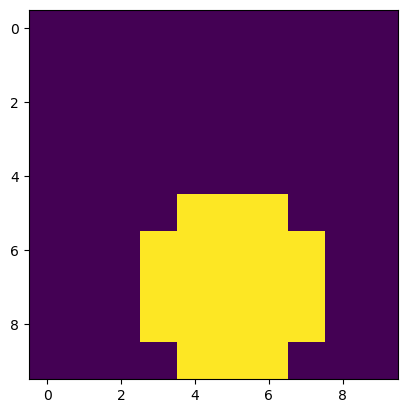

In [56]:
plt.imshow(mask[835:845,380:390])

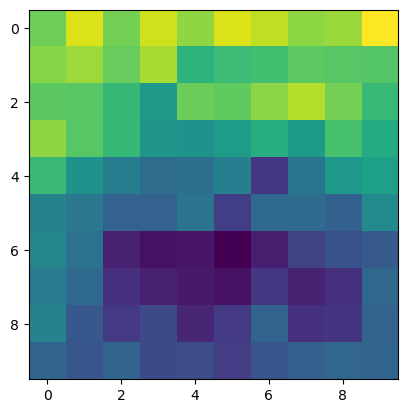

In [57]:
plt.imshow(img[835:845,380:390,0])